# Formatting Weather Data

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_weather = pd.read_csv('county_level_weather.csv')
df_weather.head()

,Unnamed: 0,County,Var,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,0,Sierra,ppt,1980,415.709686,382.501617,111.128197,79.320557,64.565422,22.852375,17.899927,5.491146,9.450271,33.582626,41.988926,120.442238
1,1,Sierra,ppt,1981,236.459885,113.850082,176.456726,44.330055,63.482513,3.611892,0.004392,0.003986,30.670328,174.779312,504.357941,377.453613
2,2,Sierra,ppt,1982,229.290253,221.140564,298.874725,318.278595,11.199191,37.534851,13.221622,5.106486,111.741684,202.075043,250.340317,253.627685
3,3,Sierra,ppt,1983,232.798508,369.659393,429.405151,169.349167,41.239933,30.229248,8.763040,30.967905,54.934071,91.135620,504.704224,429.239380
4,4,Sierra,ppt,1984,17.905682,185.402206,118.662277,81.836754,31.953772,41.990131,17.944529,9.015877,8.106352,103.931931,325.303803,62.782768


**Currently the data is quite hard to query because you have to query the Var column and then select each month. It would be a little easier if we had a column for ppt in January or VPDmax in March.**

In [0]:
#Plan: Make a bunch of series and then concat them all into a df

#List the months and variables
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
variables = df_weather['Var'].unique()

#List to store all the dfs
df_list = []

#Iterate through months
for month in months:
  
  #Filter to month
  df_month = df_weather[['County', 'Year','Var', month]]
  
  #Iterate through vars
  for var in variables:
    
    #Name column
    desired_name = month+ '_' + var
   
    #Filter to variables
    df_month_var = df_month.loc[df_month['Var'] == var].rename(columns = {month:month+ '_' + var}).drop(['Var'], axis = 1)
    
    #Append to list
    df_list.append(df_month_var)


**We have a list of all of our dfs. We now want to merge them on county and year. We can use [reduce()](https://book.pythontips.com/en/latest/map_filter.html) from functools to do a "rolling" computation.**

In [0]:
from functools import reduce
df_weather_merged = reduce(lambda  left,right: pd.merge(left,right,on=['County', 'Year'],
                                            how='outer'), df_list)

**Check out the result. This will be much easier to query!**

In [5]:
df_weather_merged.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,July_tmin,July_tmean,July_vpdmax,July_vpdmin,August_ppt,August_tmax,August_tmin,August_tmean,August_vpdmax,August_vpdmin,September_ppt,September_tmax,September_tmin,September_tmean,September_vpdmax,September_vpdmin,October_ppt,October_tmax,October_tmin,October_tmean,October_vpdmax,October_vpdmin,November_ppt,November_tmax,November_tmin,November_tmean,November_vpdmax,November_vpdmin,December_ppt,December_tmax,December_tmin,December_tmean,December_vpdmax,December_vpdmin
0,Sierra,1980,415.709686,6.415811,-3.536688,1.439561,4.567096,0.900473,382.501617,8.022836,-2.534324,2.744257,5.629257,0.789730,111.128197,7.917772,-5.233783,1.341993,6.811284,0.682297,79.320557,13.614462,-1.097838,6.258314,10.897299,1.161824,64.565422,15.683310,0.992230,8.337770,11.865405,0.895135,22.852375,19.245747,3.274729,11.260235,17.064259,1.857500,17.899927,26.238316,8.823446,17.530876,27.083784,3.966961,5.491146,26.291409,7.511015,16.901215,26.967834,4.109053,9.450271,23.308172,5.381148,14.344664,22.066820,3.330068,33.582626,19.002371,2.778716,10.890538,18.790813,3.336960,41.988926,12.337703,-1.470270,5.433717,10.158244,1.870744,120.442238,9.734934,-2.962905,3.386014,7.433448,1.787973
1,Sierra,1981,236.459885,8.395609,-2.993514,2.701048,6.016489,1.165946,113.850082,8.561417,-4.455543,2.052938,6.531755,0.810541,176.456726,8.589664,-3.696690,2.446487,6.609324,0.625608,44.330055,15.086349,-0.506689,7.289832,12.669528,1.405135,63.482513,17.870880,2.478244,10.174561,14.247837,1.583581,3.611892,25.063646,7.333107,16.198380,26.455404,4.156149,0.004392,28.257565,7.969191,18.113373,30.818111,5.258446,0.003986,29.495882,9.242567,19.369221,34.532028,5.360677,30.670328,25.396759,5.445946,15.421350,26.011009,3.415271,174.779312,14.616889,-0.292500,7.162194,11.256150,1.253851,504.357941,9.719727,-0.623716,4.548007,6.220675,1.111013,377.453613,7.190676,-2.197568,2.496554,4.770134,0.884527
2,Sierra,1982,229.290253,3.619055,-7.895067,-2.138007,4.508716,0.764730,221.140564,7.794862,-4.801757,1.496554,5.964256,0.856622,298.874725,5.931688,-4.472634,0.729527,4.644662,0.493378,318.278595,9.859526,-3.423514,3.218006,8.250746,0.886622,11.199191,19.200678,2.442703,10.821689,16.439463,1.980878,37.534851,20.913446,4.078379,12.495912,16.954527,1.311554,13.221622,25.221491,7.598379,16.409931,23.902836,3.263716,5.106486,26.666210,8.076621,17.371418,25.862032,3.914392,111.741684,20.428988,4.299663,12.364326,17.916489,2.294729,202.075043,14.318782,0.560473,7.439631,10.204461,1.237770,250.340317,7.082770,-3.927905,1.577433,5.511013,0.724324,253.627685,4.673042,-6.284797,-0.805878,4.395406,0.615068
3,Sierra,1983,232.798508,7.183243,-4.538581,1.322331,5.768040,1.109189,369.659393,6.143716,-4.080744,1.031487,4.689865,0.672567,429.405151,5.728377,-3.414798,1.156790,3.593446,0.883919,169.349167,8.240340,-3.730946,2.254696,6.202703,0.910338,41.239933,17.409866,0.840338,9.125099,15.240196,2.710608,30.229248,21.372906,4.908716,13.140814,17.596886,2.231351,8.763040,23.608381,5.796889,14.702637,22.666622,2.862297,30.967905,25.138783,8.469391,16.804085,22.499729,2.858041,54.934071,23.404596,6.214055,14.809326,22.009392,2.949595,91.135620,17.815269,2.856553,10.335910,12.967708,1.684392,504.704224,6.938378,-2.210204,2.364088,4.500947,0.763649,429.239380,4.178243,-3.234460,0.471892,3.131824,0.621014
4,Sierra,1984,17.905682,8.866152,-4.531350,2.167399,7.160810,1.510743,185.402206,8.097907,-5.463446,1.317230,6.747838,1.062432,118.662277,12.030677,-2.222230,4.904224,8.955407,1.446283,81.836754,11.395063,-3.061217,4.166926,9.403650,1.212905,31.9537

# Yield Data

**Crop Selection**

**Load in yield data. Inspect it.**

In [6]:
df_yield = pd.read_csv('California Crop Yields.csv')

#Filter out the non-county rows
df_counties = df_yield[df_yield['County Code'] < 900].drop('Unnamed: 0', axis = 1)

#Inspect
df_counties.head()

,Year,Commodity Code,Crop Name,County Code,County,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
0,1980,261999,ALMONDS ALL,7,Butte,31468.0,0.42,13217.0,3000.0,TONS,39651000.0
1,1980,261999,ALMONDS ALL,9,Calaveras,NaN,NaN,12.0,3600.0,TONS,43200.0
2,1980,261999,ALMONDS ALL,11,Colusa,14000.0,0.15,2100.0,2800.0,TONS,5880000.0
3,1980,261999,ALMONDS ALL,13,Contra Costa,2990.0,0.19,568.0,1440.0,TONS,818000.0
4,1980,261999,ALMONDS ALL,19,Fresno,23992.0,0.59,14200.0,3000.0,TONS,42600000.0


In [7]:
df_counties['Crop Name'].unique()

array(['ALMONDS ALL', 'GRAPES WINE', 'WALNUTS ENGLISH',
       'TOMATOES PROCESSING', 'PISTACHIOS', 'GRAPES TABLE',
       'LETTUCE HEAD', 'BERRIES STRAWBERRIES PROCESSING'], dtype=object)

# Join Yield and Weather

**Next step is to introduce the yield data which was obtained in a seperate notebook. We want to join this to the weather data on county and year.**

In [8]:
df_yield = pd.read_csv('California Crop Yields.csv')

#Filter out the non-county rows
df_counties = df_yield[df_yield['County Code'] < 900].drop('Unnamed: 0', axis = 1)

#Inspect
df_counties.head()

,Year,Commodity Code,Crop Name,County Code,County,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
0,1980,261999,ALMONDS ALL,7,Butte,31468.0,0.42,13217.0,3000.0,TONS,39651000.0
1,1980,261999,ALMONDS ALL,9,Calaveras,NaN,NaN,12.0,3600.0,TONS,43200.0
2,1980,261999,ALMONDS ALL,11,Colusa,14000.0,0.15,2100.0,2800.0,TONS,5880000.0
3,1980,261999,ALMONDS ALL,13,Contra Costa,2990.0,0.19,568.0,1440.0,TONS,818000.0
4,1980,261999,ALMONDS ALL,19,Fresno,23992.0,0.59,14200.0,3000.0,TONS,42600000.0


**Perform join.**

In [9]:
#Join on county and year fields. Use inner join b/c we want data that has BOTH
#yield and weather data
df_weather_yield = df_weather_merged.merge(df_counties, how = 'inner', on = ['County', 'Year'])

#Inspect
df_weather_yield.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,July_vpdmin,August_ppt,August_tmax,August_tmin,August_tmean,August_vpdmax,August_vpdmin,September_ppt,September_tmax,September_tmin,September_tmean,September_vpdmax,September_vpdmin,October_ppt,October_tmax,October_tmin,October_tmean,October_vpdmax,October_vpdmin,November_ppt,November_tmax,November_tmin,November_tmean,November_vpdmax,November_vpdmin,December_ppt,December_tmax,December_tmin,December_tmean,December_vpdmax,December_vpdmin,Commodity Code,Crop Name,County Code,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
0,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,5.283423,0.0,31.901814,13.363755,22.632778,33.683151,3.687382,0.000000,29.950806,12.481747,21.216278,28.104429,2.586510,2.793892,27.311007,10.023418,18.667212,25.811546,2.178456,3.032283,20.150541,5.482752,12.816646,14.114425,1.312014,52.204903,13.482215,3.379866,8.431041,5.867652,0.580940,216299,GRAPES WINE,67,3350.0,8.00,26800.0,210.0,TONS,5628000.0
1,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,5.283423,0.0,31.901814,13.363755,22.632778,33.683151,3.687382,0.000000,29.950806,12.481747,21.216278,28.104429,2.586510,2.793892,27.311007,10.023418,18.667212,25.811546,2.178456,3.032283,20.150541,5.482752,12.816646,14.114425,1.312014,52.204903,13.482215,3.379866,8.431041,5.867652,0.580940,263999,WALNUTS ENGLISH,67,410.0,0.90,369.0,951.0,TONS,351000.0
2,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,5.283423,0.0,31.901814,13.363755,22.632778,33.683151,3.687382,0.000000,29.950806,12.481747,21.216278,28.104429,2.586510,2.793892,27.311007,10.023418,18.667212,25.811546,2.178456,3.032283,20.150541,5.482752,12.816646,14.114425,1.312014,52.204903,13.482215,3.379866,8.431041,5.867652,0.580940,378299,TOMATOES PROCESSING,67,8560.0,28.97,248000.0,48.0,TONS,11805000.0
3,Sacramento,1981,132.503296,12.433155,5.035637,8.734395,4.878793,0.624967,24.492683,16.945038,5.507786,11.226409,8.647316,0.762550,100.797523,17.332417,6.301610,11.817011,9.076510,1.053423,22.273756,23.055368,7.915167,15.485265,16.645231,1.482886,11.681477,27.654425,11.198589,19.426498,25.817116,2.826376,0.000000,34.325500,15.843218,25.084354,42.518917,5.894967,0.000000,34.755516,...,4.926377,0.0,33.399597,14.123021,23.761307,35.922150,3.411410,6.128726,30.764835,13.483758,22.124290,30.313221,2.590134,55.972904,23.656918,9.064226,16.360571,18.346979,1.604698,156.213425,18.630539,9.027248,13.828894,9.326442,1.325437,94.639305,13.234232,5.938120,9.586173,4.598120,0.765839,216299,GRAPES WINE,67,3350.0,6.99,23400.0,224.0,TONS,5242000.0

# Feature Engineering

**It is possible that cumulative precipitation is more useful than the precipitation in one month. Sum up three months of precipitation data.**

**Jan + Feb + Mar = JPM**
**Feb + Mar + Apr = FMA Precip**

**So on and so forth...**

In [0]:
#Function to add a "window" of precipitation
def precip_window(month_window):

  #Create name
  var = month_window[0][0] + month_window[1][0] + month_window[2][0]
  var_ppt = var + '_ppt'

  #Make new column
  df_weather_yield[var_ppt] = df_weather_yield[month_window[0]] + df_weather_yield[month_window[1]] + df_weather_yield[month_window[2]]


In [0]:
#List of all posisble windows
windows = [['January_ppt', 'February_ppt', 'March_ppt'],
           ['February_ppt', 'March_ppt', 'April_ppt'],
           ['March_ppt', 'April_ppt', 'May_ppt'],
           ['April_ppt', 'May_ppt', 'June_ppt'],
           ['May_ppt', 'June_ppt', 'July_ppt'],
           ['June_ppt', 'July_ppt', 'August_ppt'],
           ['July_ppt', 'August_ppt', 'September_ppt'],
           ['August_ppt', 'September_ppt', 'October_ppt'],
           ['September_ppt', 'October_ppt', 'November_ppt'],
           ['October_ppt', 'November_ppt', 'December_ppt'],
           ['November_ppt', 'December_ppt', 'January_ppt'],
            ['December_ppt', 'January_ppt', 'February_ppt']]

#Use function
for window in windows:
  precip_window(window)

**In our model it will be important to consider the squares of some of our variables. We can add those columns now.**

In [0]:
#We don't want to square these!
unaltered_vars = ['Year','County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']

for column in list(df_weather_yield.columns):
  
  if column in unaltered_vars:
    continue
    
  else:
    name = column
    new_name = column + '_2'
    
    df_weather_yield[new_name] = df_weather_yield.apply(lambda x: x[name]**2, axis = 1)

**Inspect output. Should be over 170 columns. The variables we didn't square are still there, they are just not displayed in this output.**

In [13]:
df_weather_yield.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,August_tmin_2,August_tmean_2,August_vpdmax_2,August_vpdmin_2,September_ppt_2,September_tmax_2,September_tmin_2,September_tmean_2,September_vpdmax_2,September_vpdmin_2,October_ppt_2,October_tmax_2,October_tmin_2,October_tmean_2,October_vpdmax_2,October_vpdmin_2,November_ppt_2,November_tmax_2,November_tmin_2,November_tmean_2,November_vpdmax_2,November_vpdmin_2,December_ppt_2,December_tmax_2,December_tmin_2,December_tmean_2,December_vpdmax_2,December_vpdmin_2,JFM_ppt_2,FMA_ppt_2,MAM_ppt_2,AMJ_ppt_2,MJJ_ppt_2,JJA_ppt_2,JAS_ppt_2,ASO_ppt_2,SON_ppt_2,OND_ppt_2,NDJ_ppt_2,DJF_ppt_2
0,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,178.589954,512.242648,1134.554678,13.596789,0.000000,897.050760,155.794000,450.130456,789.858943,6.690035,7.805835,745.891079,100.468917,348.464786,666.235924,4.745669,9.194738,406.044315,30.060573,164.266405,199.216985,1.721379,2725.351861,181.770119,11.423492,71.082448,34.429339,0.337491,141590.016414,69245.995971,10562.650952,1955.283593,780.287255,254.62091,226.344939,7.805835,33.944315,3367.605970,39882.113163,136176.602542
1,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,178.589954,512.242648,1134.554678,13.596789,0.000000,897.050760,155.794000,450.130456,789.858943,6.690035,7.805835,745.891079,100.468917,348.464786,666.235924,4.745669,9.194738,406.044315,30.060573,164.266405,199.216985,1.721379,2725.351861,181.770119,11.423492,71.082448,34.429339,0.337491,141590.016414,69245.995971,10562.650952,1955.283593,780.287255,254.62091,226.344939,7.805835,33.944315,3367.605970,39882.113163,136176.602542
2,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,178.589954,512.242648,1134.554678,13.596789,0.000000,897.050760,155.794000,450.130456,789.858943,6.690035,7.805835,745.891079,100.468917,348.464786,666.235924,4.745669,9.194738,406.044315,30.060573,164.266405,199.216985,1.721379,2725.351861,181.770119,11.423492,71.082448,34.429339,0.337491,141590.016414,69245.995971,10562.650952,1955.283593,780.287255,254.62091,226.344939,7.805835,33.944315,3367.605970,39882.113163,136176.602542
3,Sacramento,1981,132.503296,12.433155,5.035637,8.734395,4.878793,0.624967,24.492683,16.945038,5.507786,11.226409,8.647316,0.762550,100.797523,17.332417,6.301610,11.817011,9.076510,1.053423,22.273756,23.055368,7.915167,15.485265,16.645231,1.482886,11.681477,27.654425,11.198589,19.426498,25.817116,2.826376,0.000000,34.325500,15.843218,25.084354,42.518917,5.894967,0.000000,34.755516,...,199.459726,564.599699,1290.400836,11.637720,37.561277,946.475095,181.811729,489.484229,918.891366

**Now we are going to center all of our variables on their respective mean over the domain. Achieved by subtracting each column by its mean. We will groupby the crop name.**

In [14]:
#Groupby
df_means = df_weather_yield.groupby('Crop Name').mean()
df_means = df_means.reset_index()

#Inspect
df_means.head()

,Crop Name,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,August_tmin_2,August_tmean_2,August_vpdmax_2,August_vpdmin_2,September_ppt_2,September_tmax_2,September_tmin_2,September_tmean_2,September_vpdmax_2,September_vpdmin_2,October_ppt_2,October_tmax_2,October_tmin_2,October_tmean_2,October_vpdmax_2,October_vpdmin_2,November_ppt_2,November_tmax_2,November_tmin_2,November_tmean_2,November_vpdmax_2,November_vpdmin_2,December_ppt_2,December_tmax_2,December_tmin_2,December_tmean_2,December_vpdmax_2,December_vpdmin_2,JFM_ppt_2,FMA_ppt_2,MAM_ppt_2,AMJ_ppt_2,MJJ_ppt_2,JJA_ppt_2,JAS_ppt_2,ASO_ppt_2,SON_ppt_2,OND_ppt_2,NDJ_ppt_2,DJF_ppt_2
0,ALMONDS ALL,1997.301611,110.623265,12.389855,2.359652,7.374732,6.463695,0.807701,105.381114,14.947290,3.597087,9.272165,8.664804,0.901527,91.221750,17.556253,5.091729,11.323967,11.443267,1.106157,41.376073,20.872173,6.660087,13.766105,16.400804,1.619092,21.278350,25.351808,9.865464,17.608600,23.190183,2.640767,7.464915,29.880421,13.158620,21.519484,31.173985,4.026923,1.606138,33.243613,...,230.002628,575.241073,1363.213972,28.689724,350.777791,913.092668,175.693672,471.847583,1038.396307,21.914561,2014.436476,615.779842,91.173102,294.318698,499.520287,9.151880,8648.767436,298.139562,28.204027,125.371606,129.435364,1.969390,18495.355694,156.151558,9.165245,55.279907,50.872646,1.020680,133678.527321,80962.441332,37108.636898,8500.504546,2133.529051,302.686748,472.344436,3370.360953,18797.110677,60327.785747,111786.702661,138588.150632
1,BERRIES STRAWBERRIES PROCESSING,2000.093525,95.252431,16.143829,4.111828,10.127803,11.117152,1.802205,104.798256,16.421680,4.554985,10.488307,10.943371,1.485443,72.602970,18.246774,5.561163,11.903944,12.428462,1.408353,27.258474,20.419955,6.548414,13.484160,15.509216,1.570631,10.384542,23.158405,8.829649,15.993991,18.592306,2.009779,2.467148,26.442803,11.330147,18.886438,23.724028,2.828512,2.280105,29.236967,...,203.002471,477.864810,851.417176,17.882878,86.328783,789.341955,163.318976,416.641289,731.949504,14.201933,1492.939904,602.878337,101.615266,298.960019,470.408828,9.993750,2334.453923,386.424086,44.136641,171.499466,232.726529,5.819643,9424.247189,256.082209,16.701608,98.351677,139.862368,4.386608,109605.478755,60698.491182,19909.518749,3115.912214,578.142967,155.184400,248.911214,1831.835924,5712.621075,25308.070421,58372.562485,101507.027134
2,GRAPES TABLE,1997.850000,73.016340,13.025080,1.908467,7.466759,8.204060,1.268864,70.470513,15.315059,3.035260,9.175142,10.296896,1.324041,60.277594,18.190238,4.783318,11.486760,13.588679,1.675944,28.938043,21.541678,6.699367,14.120504,19.053373,2.499448,13.519073,25.983597,10.192513,18.088026,26.127323,3.962421,4.367276,30.655252,13.810149,22.232670,35.056137,6.051969,3.693540,33.867030,...,281.971111,633.467247,1637.748564,61.229695,181.028913,942.449765,203.331135,504.002616,1201.849007,39.979415,942.593049,635.551291,99.554691,308.133119,592.008154,17.472742,2471.352442,327.446514,28.000466,134.183165,195.463298,5.731325,6974.157077,174.190298,7.873605,57.685106,85.254511,2.807212,62870.332228,38442.116612,18223.092406,4257.971683,1053.895016,337.288391,522.358936,1721.918054,6283.580303,21505.075383,42725.702788,60298.096498
3,GRAPES WINE,1999.517872,123.727600,13.070621,2.696191,7.883380,7.544411,1.085366,120.886228,14.835431,3.611339,9.223357,9.045732,1.072916,101.070670,17.147304,4.922591,11.034919,11.432616,1.255848,48.863188,19.877208,6.232437,13.054794,15.356698,1.696491,23.302282,23.871160,9.117594,16.494333,20.890985,2.573136,7.544652,28.144968,12.162638,20.153759,28.156031,3.920326,2.185305,31.360761,

**Next step is to center our data on the respective mean.**

In [0]:
#Make a deep copy of df_weather_yield to preserve the original
df_centered = df_weather_yield.copy(deep = True)

#Specify variables
variables = list(df_weather_yield.columns)
crops = df_weather_yield['Crop Name'].unique()

#List of variables we don't want to subtract mean from
unaltered_vars = ['County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']


for crop in crops:

  for var in variables:
    
    if var in unaltered_vars:
      continue
      
    else:
      #Extract mean of variable for specific crop
      var_mean = df_means.loc[df_means['Crop Name'] == crop,var].values[0]
      
      #Subtract the mean from the original data
      result = df_weather_yield[df_weather_yield['Crop Name'] == crop][var] - var_mean
      
      #Save result in df_centered
      df_centered.loc[df_centered['Crop Name'] == crop, var] = result

**Now we can check out our centered data.**

In [16]:
df_centered.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,August_tmin_2,August_tmean_2,August_vpdmax_2,August_vpdmin_2,September_ppt_2,September_tmax_2,September_tmin_2,September_tmean_2,September_vpdmax_2,September_vpdmin_2,October_ppt_2,October_tmax_2,October_tmin_2,October_tmean_2,October_vpdmax_2,October_vpdmin_2,November_ppt_2,November_tmax_2,November_tmin_2,November_tmean_2,November_vpdmax_2,November_vpdmin_2,December_ppt_2,December_tmax_2,December_tmin_2,December_tmean_2,December_vpdmax_2,December_vpdmin_2,JFM_ppt_2,FMA_ppt_2,MAM_ppt_2,AMJ_ppt_2,MJJ_ppt_2,JJA_ppt_2,JAS_ppt_2,ASO_ppt_2,SON_ppt_2,OND_ppt_2,NDJ_ppt_2,DJF_ppt_2
0,Sacramento,-19.517872,20.740280,-0.332633,2.561527,1.114472,-3.826089,-0.705298,51.462131,1.382085,3.392286,2.387217,-2.117276,-0.408017,-41.602420,0.719275,0.810764,0.765052,-0.444225,-0.005109,-17.533457,1.936612,1.986958,1.961813,0.252028,0.215656,-11.325504,1.295359,0.533682,0.914561,0.438214,-0.331122,-6.632571,-0.392823,-0.708411,-0.550571,-0.759383,0.014305,12.859459,1.865348,...,-39.001454,-16.236773,-52.424368,-20.258873,-306.984038,50.280298,-13.444360,8.152734,-141.248651,-18.037428,-3243.643010,163.298925,8.789258,65.866454,196.988997,-6.420611,-11084.379289,100.890740,-3.169554,32.012222,50.274700,-1.688537,-25746.637431,8.434934,-1.376416,6.508699,-35.003605,-1.634312,-39902.844435,-41524.664924,-40602.616502,-9969.852314,-1943.558150,-175.569310,-329.310825,-4654.494886,-24008.312101,-83012.296672,-117389.541894,-60175.016319
1,Sacramento,-17.262755,17.726157,0.164066,2.818945,1.491524,-3.131157,-0.541901,49.176713,1.543933,3.497813,2.520898,-1.710047,-0.300709,-45.742728,0.838901,0.918844,0.878898,-0.070931,0.123972,-17.572201,1.728103,2.000793,1.864470,0.213417,0.355281,-13.506325,0.837967,0.423523,0.630775,-0.089689,-0.195641,-7.773872,-0.992160,-0.926748,-0.959418,-1.543831,0.194475,13.282301,1.100804,...,-34.677372,-27.063548,-103.675689,-14.574769,-456.194771,29.762071,-9.409133,3.552877,-165.595380,-15.246231,-2970.971595,155.874251,12.457005,66.165266,196.676917,-4.808660,-12475.524924,113.416519,0.938720,39.978805,68.925641,-0.554203,-23692.755932,21.278480,1.167434,13.080836,-21.964266,-0.994823,-39559.677239,-41939.473290,-40968.190916,-10275.847237,-2276.660229,-183.201607,-422.735205,-4831.223097,-26884.713556,-83336.805428,-116305.661164,-55616.154010
2,Sacramento,-16.895935,56.351026,-0.744106,1.972108,0.614020,-3.429407,-0.509383,86.803677,0.244839,2.453425,1.349156,-2.389781,-0.325616,-10.965807,-0.678268,-0.296797,-0.487509,-1.190495,0.007207,0.263073,0.065069,0.711473,0.388291,-1.566495,0.132719,-1.919114,-0.703158,-0.774210,-0.738654,-2.261346,-0.508504,-3.206749,-2.369750,-1.988975,-2.179327,-3.959550,-0.135714,13.874031,0.114802,...,-62.820584,-70.243244,-185.336823,-13.600371,-179.020621,-35.188106,-36.371920,-41.372953,-253.073070,-13.758346,-1072.982948,95.615702,-6.722957,28.292118,135.052709,-5.180663,-4076.683368,69.432048,-7.930564,16.026466,42.991311,-1.151721,-6827.537754,-5.773901,-2.560635,-0.701441,-32.732269,-1.199811,57599.731718,20039.517805,-9517.062063,-2008.162392,-49.027823,92.107638,-76.911696,-1766.306855,-9002.016334,-26452.007631,-20509.330697,53304.533205
3,Sacramento,-18.517872,8.775696,-0.637466,2.339446,0.851015,-2.665618,-0.460399,-96.393544,2.109607,1.896446,2.003052,-0.398416,-0.310366,-0.273146,0.185112,1.379018,0.782092,-2.356106,-0.202424,-26.589432,3.178160,1.682730,2.430471,1.288533,-0.213605,-11.620805,3.783265,2.080995,2.932166,4.926131,0.253240,-7.544652,6.180532,3.680579,4.930596,14.362886,1.974640,-2.185305,3.394755,...,

# Exploratory Analysis

In [0]:
df_vars = pd.concat([df_corr.head(3), df_corr.tail(3)])
vars = list(df_vars['Variable'].values)

def plot_matrix(vars, crop, corr_values):
  fig, axes = plt.subplots(2, 3, figsize = (15,15), sharey = True)

  sns.scatterplot(x = vars[0], y = 'Production', data = df_almond_model, ax =axes[0,0])
  axes[0,0].set_title('r = ' + str(round(corr_values[0],3)))

  sns.scatterplot(x = vars[1], y = 'Production', data = df_almond_model, ax =axes[0,1])
  axes[0,1].set_title('r = ' + str(round(corr_values[1],3)))

  sns.scatterplot(x = vars[2], y = 'Production', data = df_almond_model, ax =axes[0,2])
  axes[0,2].set_title('r = ' + str(round(corr_values[2],3)))

  sns.scatterplot(x = vars[3], y = 'Production', data = df_almond_model, ax =axes[1,0])
  axes[1,0].set_title('r = ' + str(round(corr_values[3],3)))

  sns.scatterplot(x = vars[4], y = 'Production', data = df_almond_model, ax =axes[1,1])
  axes[1,1].set_title('r = ' + str(round(corr_values[4],3)))

  sns.scatterplot(x = vars[5], y = 'Production', data = df_almond_model, ax =axes[1,2])
  axes[1,2].set_title('r = ' + str(round(corr_values[5],3)))
  
  plt.suptitle(crop, fontsize = 20, x = 0.51, y = 0.93)

  

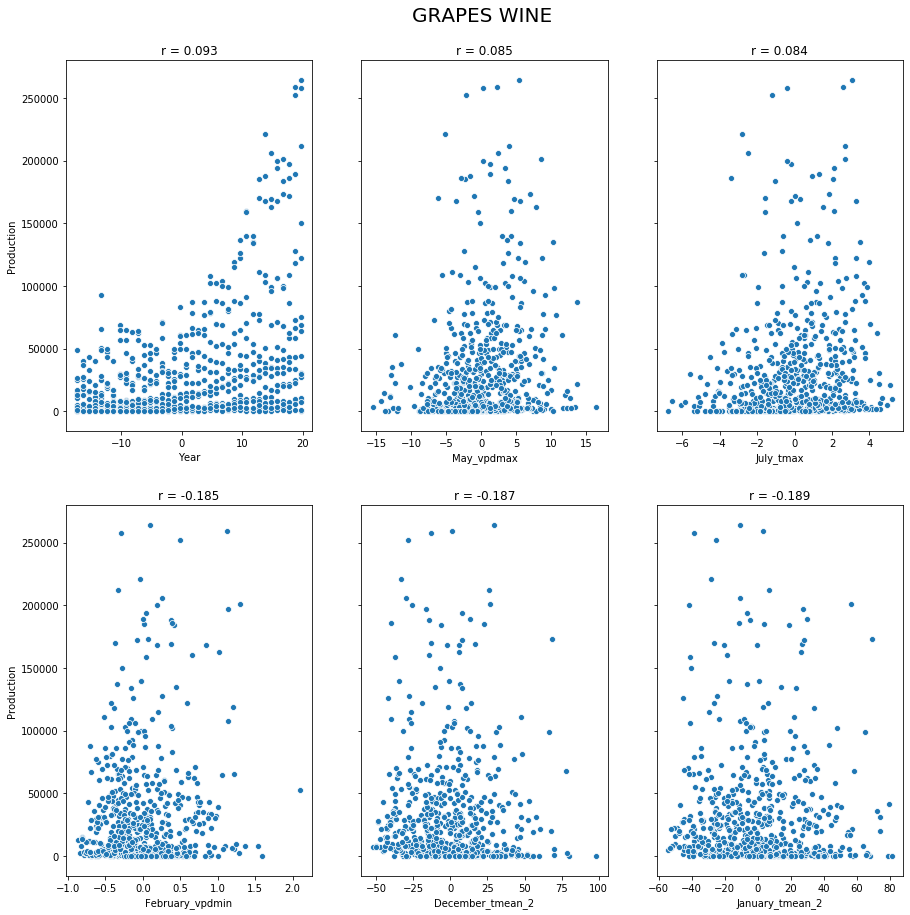

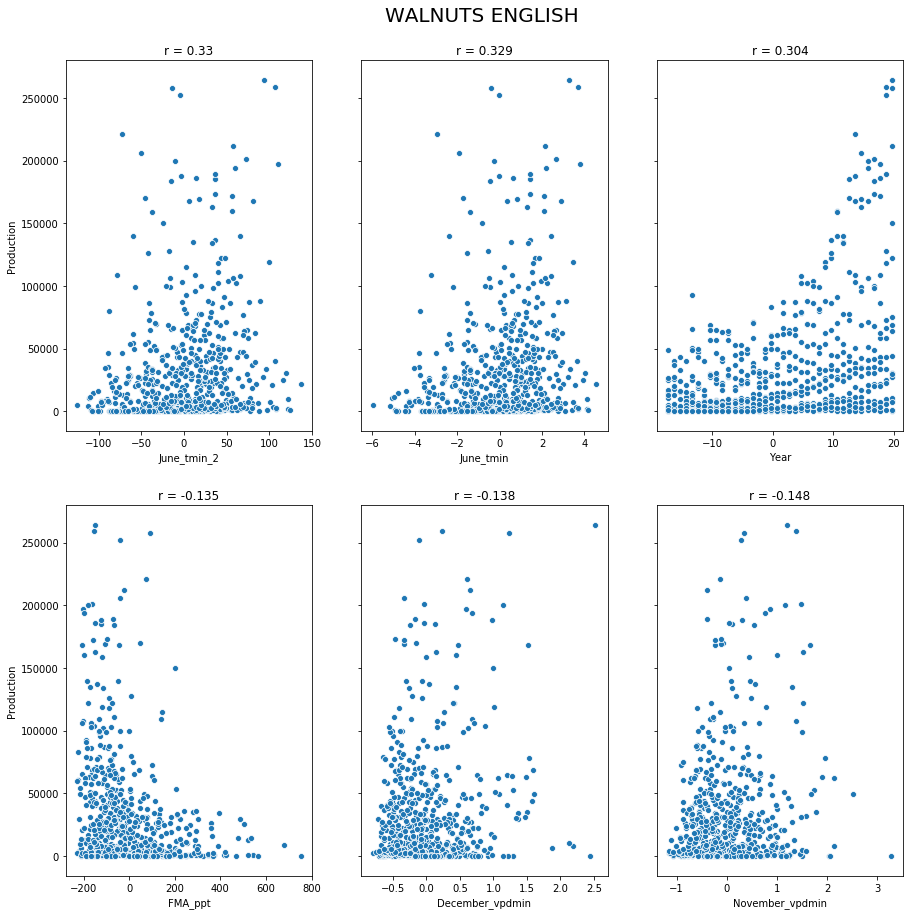

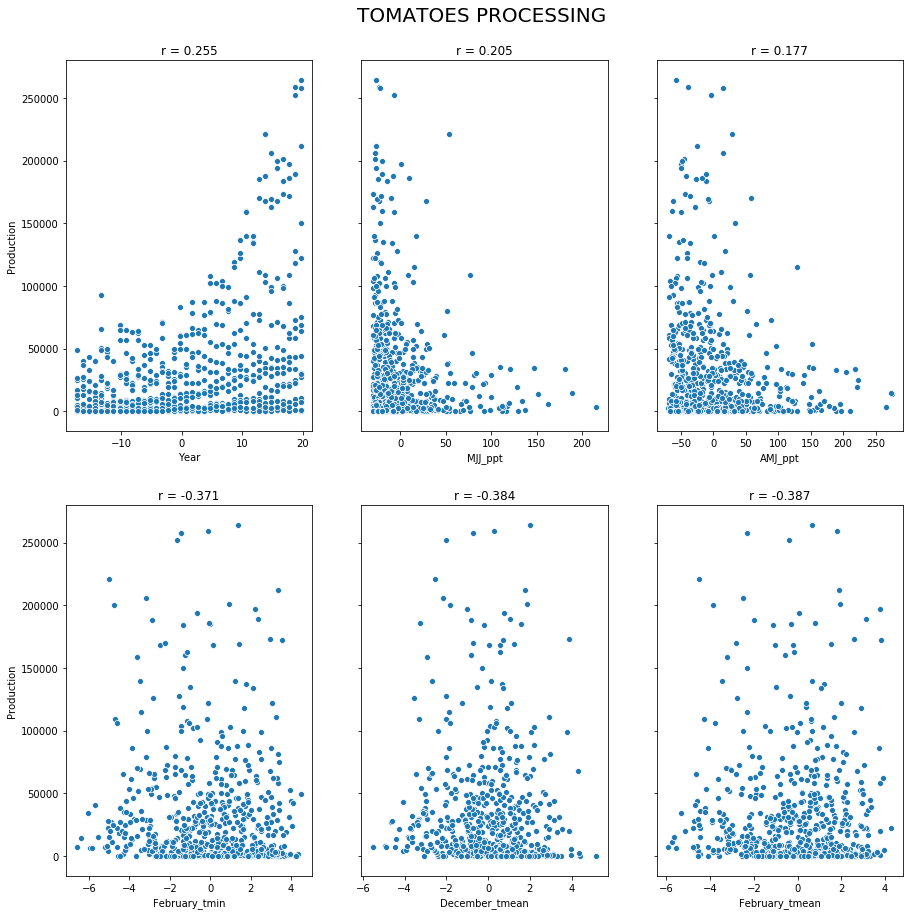

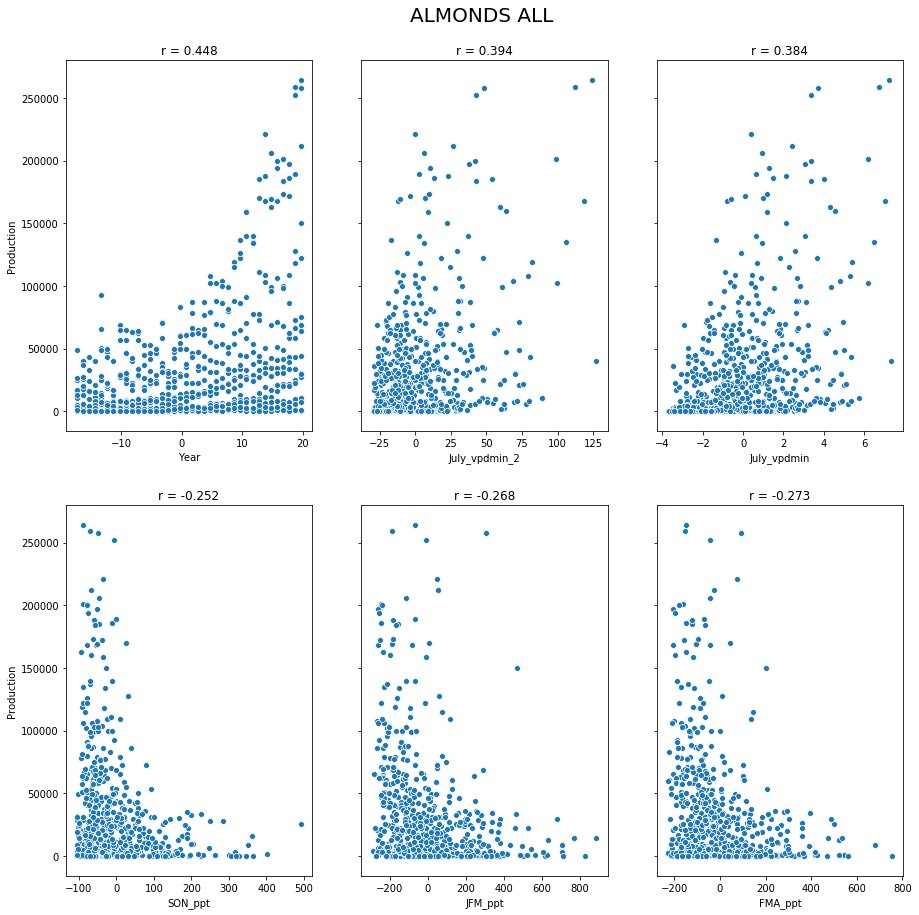

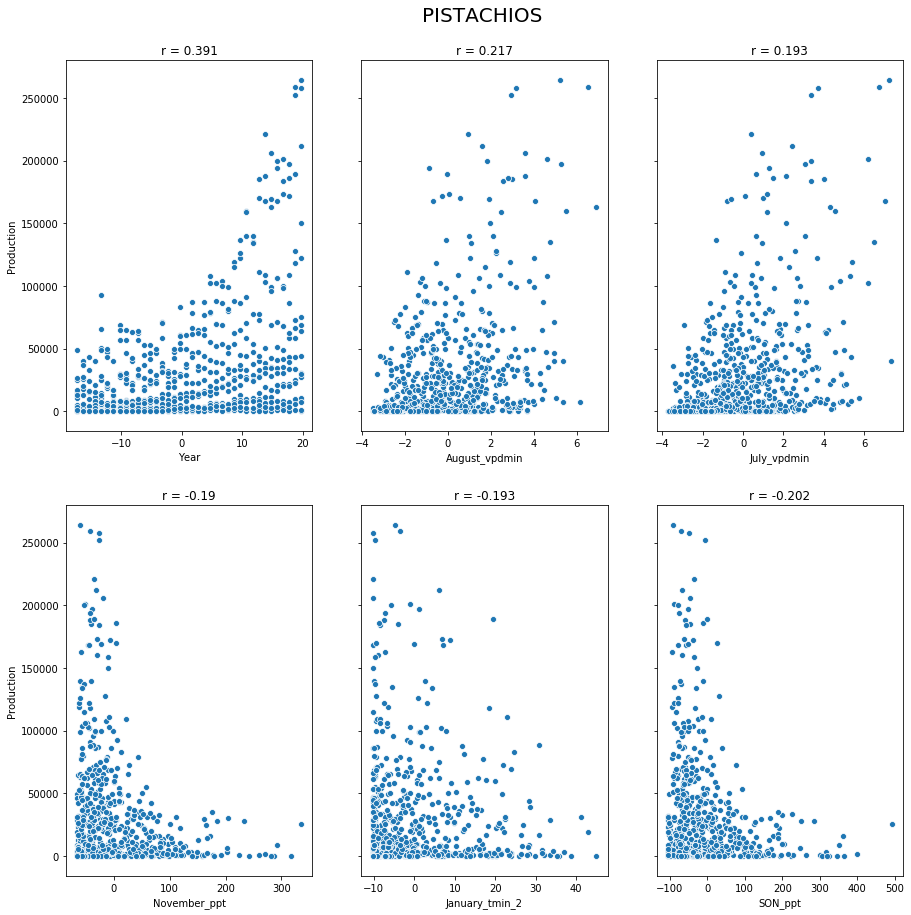

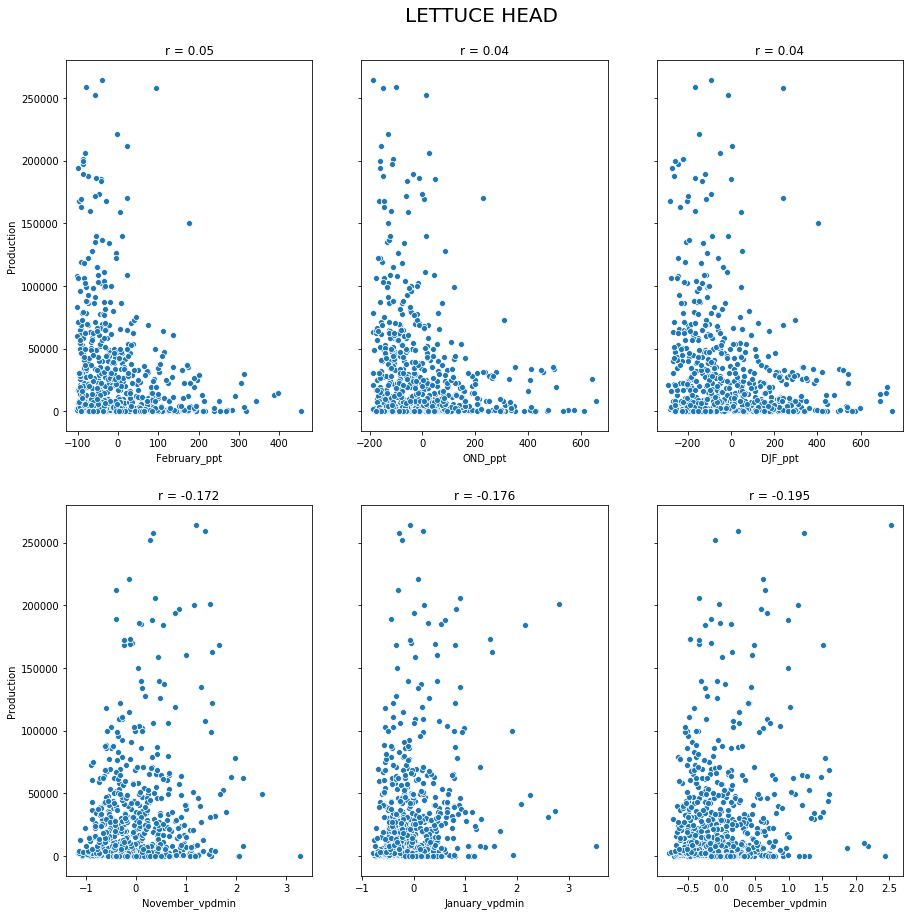

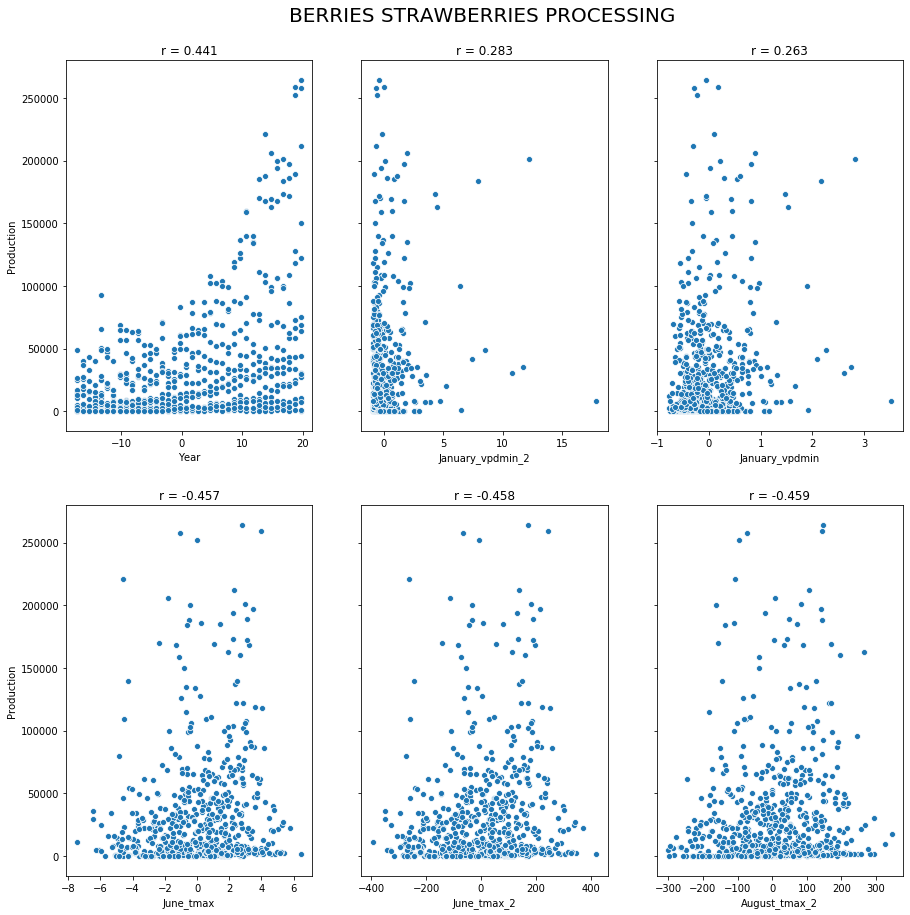

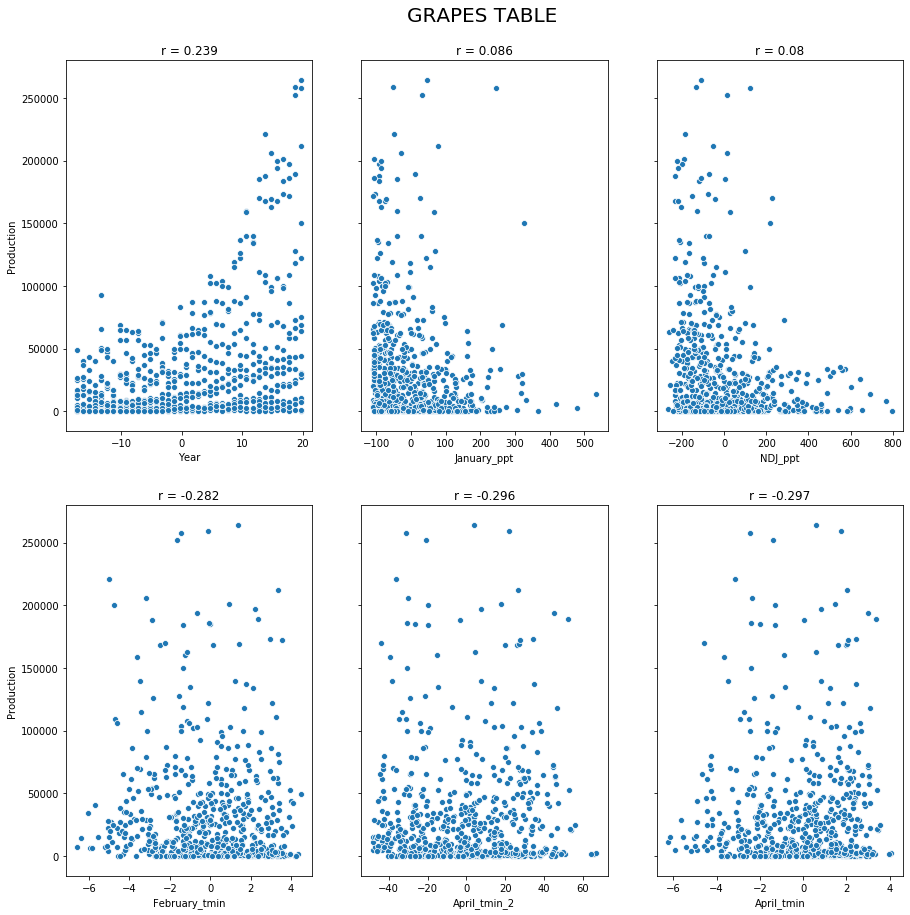

In [0]:
for crop in df_centered['Crop Name'].unique():
  
  df_crop = df_centered[df_centered['Crop Name'] == crop]
  
  df_crop = df_crop.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Price per Unit', 'Total Value','Unit', 'Crop Name'], axis = 1)
  
  df_crop = df_crop[pd.notnull(df_crop['Production'])]
  
  corrs = df_crop.drop('Production', axis=1).apply(lambda x: x.corr(df_crop['Production']))
  
  df_corr = corrs.sort_values(ascending = False).to_frame().reset_index().rename(columns = {'index':'Variable', 0:'Corr'})
  
  df_vars = pd.concat([df_corr.head(3), df_corr.tail(3)])
  
  vars = list(df_vars['Variable'].values)

  corr_values = list(df_vars['Corr'].values)
  
  plot_matrix(vars, crop, corr_values)

In [0]:
for crop in df_centered['Crop Name'].unique():
  
  df_crop = df_centered[df_centered['Crop Name'] == crop]
  
  df_crop = df_crop.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Price per Unit', 'Total Value','Unit', 'Crop Name'], axis = 1)
  
  df_crop = df_crop[pd.notnull(df_crop['Production'])]
  
  corrs = df_crop.drop('Production', axis=1).apply(lambda x: x.corr(df_crop['Production']))
  
  df_corr = corrs.sort_values(ascending = False).to_frame().reset_index().rename(columns = {'index':'Variable', 0:'Corr'})
  
  df_vars = pd.concat([df_corr.head(3), df_corr.tail(3)])
  
  vars = list(df_vars['Variable'].values)
  
  print(crop, df_vars)



# **Build Model**

https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn

https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/#four

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html

https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

**At this point we need to drop columns that will not be part of the model. We also need to make sure that any NaNs are removed.**

In [0]:
#Let's do almonds only
df_almonds = df_centered[df_centered['Crop Name'] == 'ALMONDS ALL']

df_almond_model = df_almonds.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Price per Unit', 'Total Value','Unit', 'Crop Name'], axis = 1)

#Make sure all NaN values are removed
df_almond_model = df_almond_model[pd.notnull(df_almond_model['Production'])]

**We need to split our data in training and testing sets. We will use 30% of our data to test our model.**

In [17]:
from sklearn.model_selection import train_test_split
Y = df_almond_model['Production']
X = df_almond_model.drop(['Production'], axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(466, 169) (466,)
(200, 169) (200,)


**Try playing around with alpha manually and see what happens.**

In [43]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha = 4, max_iter =1e4)
model_lasso.fit(X_train, Y_train)
pred_train_lasso= model_lasso.predict(X_train)

from sklearn.metrics import r2_score
print(r2_score(Y_train, pred_train_lasso))

0.6546392048788119


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125626590062.52873, tolerance: 71535560.41958454
  positive)


In [68]:
#How many coefs are zero?
len(np.where(model_lasso.coef_ == 0)[0])

9

In [0]:
pred_test_lasso= model_lasso.predict(X_test)
print(r2_score(Y_test, pred_test_lasso))

0.3836634985912324


**Try finding alpha using CV**

In [69]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

lasso = Lasso(max_iter = 10000, normalize = True)

lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, Y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

1651399735.111839

In [74]:
#R2 for train set
pred_train_lasso= lasso.predict(X_train)
print('Train', r2_score(Y_train, pred_train_lasso))

#R2 for test set
print('Test', r2_score(Y_test, lasso.predict(X_test)))

#MSE for train set
print('MSE train', mean_squared_error(Y_train, lasso.predict(X_train)))

#Huge MSE from test set
print('MSE test', mean_squared_error(Y_test, lasso.predict(X_test)))

Train 0.49601114298273696
Test 0.43503487107489536
MSE train 773672217.4239438
MSE test 1651399735.111839


In [70]:
df_almond_coefs = pd.Series(lasso.coef_, index = X_train.columns).to_frame(name = 'Coefs')
df_almond_coefs[df_almond_coefs['Coefs'] != 0].sort_values(by = 'Coefs')

,Coefs
April_vpdmin,-7579.148121
December_vpdmin_2,-6537.496617
October_vpdmin,-2538.580448
December_vpdmax,-2042.399990
February_vpdmax,-1846.682100
April_vpdmin_2,-1152.204650
May_tmin,-902.089652
August_ppt,-760.272969
June_tmin_2,-319.050975
December_tmin_2,-234.807052
